### Shot Difficulty Model for FA Women's Super League 2020/21

### *Goals*:
- Create a Shot Difficulty Model (i.e. Expected Goals) from the **Statsbomb** Open Data using the FA Women's Super League 2020/2021 Season with a Logistic Regression.
- Construct a table that ranks the Top 10 players by cumulative Expected Goals in the season.
- Evaluate the model with appropriate diagnostics.
- Plot a surface with `mplsoccer` that demonstrates spatial distribution of across the field.

In [2]:
# Install Some Dependancies for the
!pip install statsbombpy --quiet
!pip install mplsoccer --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.7/70.7 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.5/88.5 kB 1.9 MB/s eta 0:00:00


In [28]:
from statsbombpy import sb
from mplsoccer import Sbopen

In [4]:
# Some code to suppress warnings about not using an API key – we're using the free dataset
from statsbombpy.api_client import NoAuthWarning
import warnings
warnings.filterwarnings('ignore', category=NoAuthWarning)

In [5]:
league = {
  'competition_id': 37,
  'season_id': 90,
  'country_name': 'England',
  'competition_name': "FA Women's Super League",
  'season_name': '2020/2021'
}

In [6]:
matches = sb.matches(competition_id=league['competition_id'], season_id=league['season_id'])
matches.head()

,match_id,match_date,kick_off,competition,season,home_team,away_team,home_score,away_score,match_status,...,last_updated_360,match_week,competition_stage,stadium,referee,home_managers,away_managers,data_version,shot_fidelity_version,xy_fidelity_version
0,3775648,2021-02-28,15:00:00.000,England - FA Women's Super League,2020/2021,Aston Villa,Arsenal WFC,0,4,available,...,2021-06-13T16:17:31.694,11,Regular Season,Poundland Bescot Stadium,Lisa Benn,Marcus Bignot,Joseph Montemurro,1.1.0,2,2
1,3775609,2021-04-28,20:30:00.000,England - FA Women's Super League,2020/2021,Arsenal WFC,West Ham United LFC,2,0,available,...,2021-06-13T16:17:31.694,13,Regular Season,Meadow Park,Emily Heaslip,Joseph Montemurro,Olli Harder,1.1.0,2,2
2,3775633,2021-02-06,13:30:00.000,England - FA Women's Super League,2020/2021,Aston Villa,Tottenham Hotspur Women,1,0,available,...,2021-06-13T16:17:31.694,14,Regular Season,Poundland Bescot Stadium,Jane Simms,Marcus Bignot,Rehanne Skinner,1.1.0,2,2
3,3775570,2021-03-28,13:30:00.000,England - FA Women's Super League,2020/2021,Brighton & Hove Albion WFC,Everton LFC,0,5,available,...,2021-06-13T16:17:31.694,18,Regular Season,Broadfield Stadium,Christina Hattersley,Hope Patricia Powell,Willie Kirk,1.1.0,2,2
4,3775581,2021-03-28,15:30:00.000,England - FA Women's Super League,2020/2021,Chelsea FCW,Aston Villa,2,0,available,...,2021-06-13T16:17:31.694,18,Regular Season,Kingsmeadow,Sarah Garratt,Emma Hayes,Marcus Bignot,1.1.0,2,2


In [7]:
# Fetching Events from just the first match
match_id = matches.iloc[0]['match_id']
events = sb.events(match_id=match_id, split=True)

In [8]:
df_shots = events['shots']
print("Total Shots:", df_shots.shape[0])
df_shots.head(5)

Total Shots: 32


,id,index,period,timestamp,minute,second,type,possession,possession_team,play_pattern,...,shot_freeze_frame,possession_team_id,team_id,player_id,shot_first_time,under_pressure,shot_aerial_won,shot_one_on_one,shot_open_goal,out
0,7b6ab918-87a4-4933-85b7-d8965938a45e,92,1,00:01:27.151,1,27,Shot,5,Aston Villa,From Keeper,...,"[{'location': [101.1, 63.7], 'player': {'id': ...",2647,2647,10102,NaN,NaN,NaN,NaN,NaN,NaN
1,0ba83eaf-b15d-4879-9ee5-cba49421bd89,278,1,00:05:21.756,5,21,Shot,11,Arsenal WFC,From Corner,...,"[{'location': [115.7, 38.0], 'player': {'id': ...",968,968,15623,NaN,NaN,NaN,NaN,NaN,NaN
2,ea3ebaf8-8dcd-4147-8e41-272d77cd3546,338,1,00:06:57.808,6,57,Shot,14,Arsenal WFC,From Throw In,...,"[{'location': [101.7, 37.2], 'player': {'id': ...",968,968,10650,NaN,NaN,NaN,NaN,NaN,NaN
3,85b4eba6-a1b6-4665-85bb-c5de41a0e74d,460,1,00:10:06.492,10,6,Shot,20,Arsenal WFC,From Throw In,...,"[{'location': [98.4, 20.4], 'player': {'id': 4...",968,968,15619,NaN,NaN,NaN,NaN,NaN,NaN
4,c6ff3786-bf7f-4f81-ac6d-3acccf21073b,609,1,00:14:50.232,14,50,Shot,27,Arsenal WFC,From Corner,...,"[{'location': [112.2, 36.0], 'player': {'id': ...",968,968,18999,True,NaN,NaN,NaN,NaN,NaN


In [9]:
# If you're on a Mac with a retina display, uncomment the below line for clean plotting
# %config InlineBackend.figure_format = 'retina'

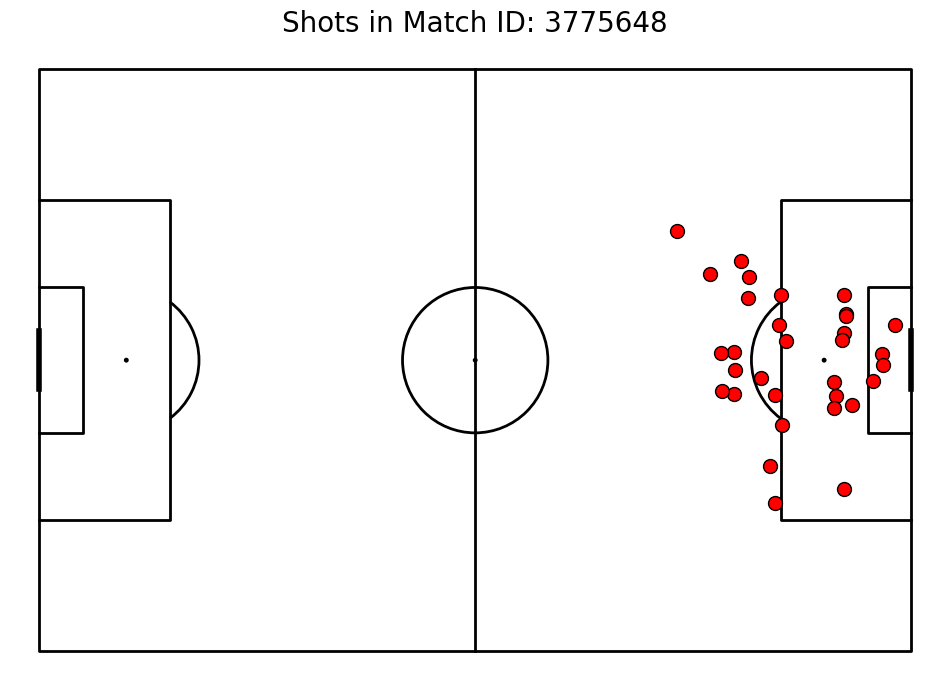

In [10]:
from mplsoccer import Pitch
import numpy as np

pitch = Pitch(pitch_type='statsbomb', line_color='black')
fig, ax = pitch.draw(figsize=(10, 7))

for i, shot in df_shots.iterrows():
    x, y = shot['location'][0], shot['location'][1]
    pitch.scatter(x, y, ax=ax, s=100, color='red', edgecolors='black', zorder=2)

ax.set_title(f"Shots in Match ID: {3775648}", fontsize=20)
fig.show()

In [11]:
# GOAL 1: Create a Shot Difficulty Model (i.e. Expected Goals) from the Statsbomb Open Data using the FA Women's Super League 2020/2021 Season with a Logistic Regression.

# STEP 1: Imports
from statsbombpy import sb
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, brier_score_loss


In [12]:
# STEP 2: Get competitions to find WSL 2020/21
comps = sb.competitions()
wsl = comps[(comps['competition_name']=="FA Women's Super League") &
            (comps['season_name']=="2020/2021")]

comp_id = int(wsl['competition_id'].iloc[0])
season_id = int(wsl['season_id'].iloc[0])

In [13]:
# STEP 3: Get all matches in this competition & season
matches = sb.matches(competition_id=comp_id, season_id=season_id)
match_ids = matches['match_id'].tolist()

In [14]:
# STEP 4: Get all shots from all matches
shots_list = []

for match in match_ids:
    events = sb.events(match_id=match)
    shots_match = events[events['type'] == 'Shot']

    # Select the relevant columns for the model
    relevant_cols = ['id', 'index', 'period', 'timestamp', 'minute', 'second', 'type', 'possession',
                     'possession_team', 'play_pattern', 'team', 'player', 'position', 'location',
                     'duration', 'related_events', 'match_id', 'shot_statsbomb_xg', 'shot_end_location',
                     'shot_key_pass_id', 'shot_technique', 'shot_body_part', 'shot_type', 'shot_outcome',
                     'shot_freeze_frame', 'possession_team_id', 'team_id', 'player_id', 'shot_first_time',
                     'under_pressure', 'shot_aerial_won', 'shot_one_on_one', 'shot_open_goal', 'out']

    # Filter shots_match to only include relevant columns, adding missing ones as None/NaN
    shots_match_filtered = shots_match.reindex(columns=relevant_cols)
    shots_list.append(shots_match_filtered)


# Combine all shots into a single DataFrame
shots = pd.concat(shots_list, ignore_index=True)

# Filter out all set pieces: penalties, direct free kicks
shots = shots[
    (~shots['shot_type'].isin(["Penalty", "Direct Free Kick"])) &   # remove penalties & direct free kicks
    (shots['shot_outcome'] != "Own Goal")] # remove own goals

In [15]:
# STEP 5: Create target (goal = 1, miss = 0)
shots['goal'] = (shots['shot_outcome']=='Goal').astype(int)

In [16]:
# STEP 6: Use shot location as features

# Add features: goal, x, y
shots['goal'] = (shots['shot_outcome'] == 'Goal').astype(int)
shots['x'] = shots['location'].apply(lambda loc: loc[0])
shots['y'] = shots['location'].apply(lambda loc: loc[1])

# Calculate Distance and Angle to Goal
# Goal is at x=120, y=36-44 (using Statsbomb coordinates)
# Center of the goal is approximately: x=120, y=40
shots['distance_to_goal'] = np.sqrt((120 - shots['x'])**2 + (40 - shots['y'])**2)

# Angle to goal - Considering both goal posts
# Goal post 1: x=120, y=36
# Goal post 2: x=120, y=44
epsilon = 1e-6  # Small value to avoid division by zero or log(0) in angle calculations

shots['angle_to_goal'] = np.degrees(
    np.arctan2(abs(shots['y'] - 40), (120 - shots['x'] + epsilon))
)

# One-hot encode categorical features
shots = pd.get_dummies(shots, columns=['shot_body_part', 'shot_technique', 'play_pattern'], dummy_na=False)

# Convert boolean columns to int (handle NaNs)
boolean_cols = ['under_pressure', 'shot_first_time', 'shot_one_on_one', 'shot_open_goal', 'shot_aerial_won']
for col in boolean_cols:
    if col in shots.columns:
        # Replace NaNs with False, cast cleanly to bool then int
        shots[col] = np.where(shots[col].isna(), False, shots[col]).astype(bool).astype(int)


In [17]:
# STEP 7: Prepare data for model
# Features and target
feature_cols = ['x', 'y', 'distance_to_goal', 'angle_to_goal', 'under_pressure',
                'shot_first_time', 'shot_one_on_one', 'shot_open_goal', 'shot_aerial_won'] + \
               [col for col in shots.columns if 'shot_body_part_' in col] + \
               [col for col in shots.columns if 'shot_technique_' in col] + \
               [col for col in shots.columns if 'play_pattern_' in col]

X = shots[feature_cols]
y = shots['goal']

In [18]:
# STEP 8: Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Fit logistic regression
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict xG for all shots and add to the shots DataFrame
shots['xg'] = model.predict_proba(X)[:, 1]

# STEP 9: Add xG predictions back to shots
# Using the same feature columns as used for training the model
shots['xg'] = model.predict_proba(shots[feature_cols])[:, 1]

In [19]:
# STEP 9: Add xG predictions back to shots
# Using the same feature columns as used for training the model
shots['xg'] = model.predict_proba(shots[feature_cols])[:, 1]

In [20]:
# GOAL 2: Construct a table that ranks the Top 10 players by cumulative Expected Goals in the season.

# Group by player and sum their predicted xG, then round to 1 decimal place
player_xg = shots.groupby("player")["xg"].sum().reset_index()
player_xg["xg"] = player_xg["xg"].round(1)

# Sort in descending order
player_xg = player_xg.sort_values("xg", ascending=False)

# Take Top 10
top10_xg = player_xg.head(10)

print("Top 10 Players by Cumulative Expected Goals (xG)")
print(top10_xg)

Top 10 Players by Cumulative Expected Goals (xG)
                        player    xg
222           Vivianne Miedema  16.6
205          Samantha May Kerr  15.9
59                 Ellen White   9.7
22             Bethany England   7.7
186  Pernille Mosegaard Harder   7.6
57                  Ella Toone   7.3
34                 Chloe Kelly   6.9
25          Caitlin Jade Foord   6.7
204        Samantha June Mewis   6.7
85             Georgia Stanway   6.3


ROC-AUC Score: 0.726
Brier Score: 0.092
Accuracy: 0.89


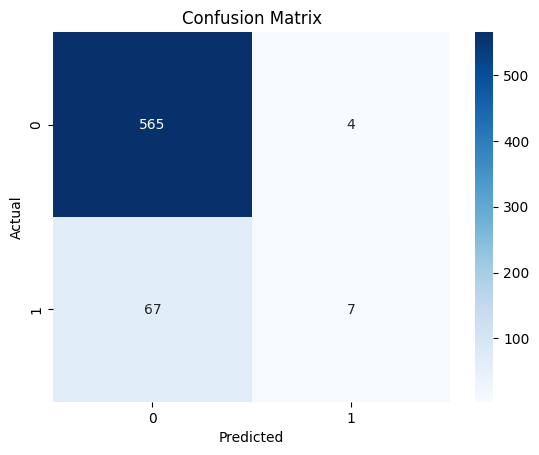

Precision: 0.636, Recall: 0.095, F1: 0.165


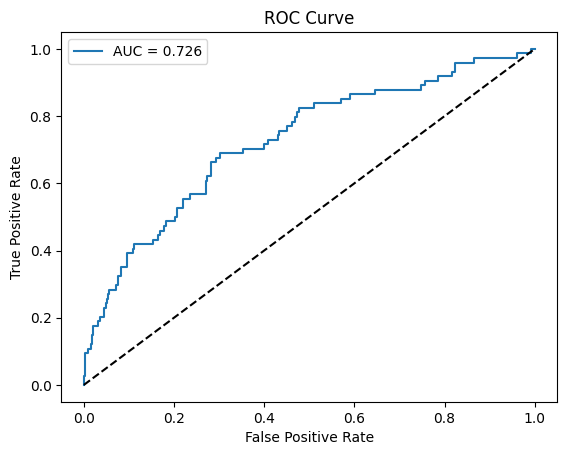

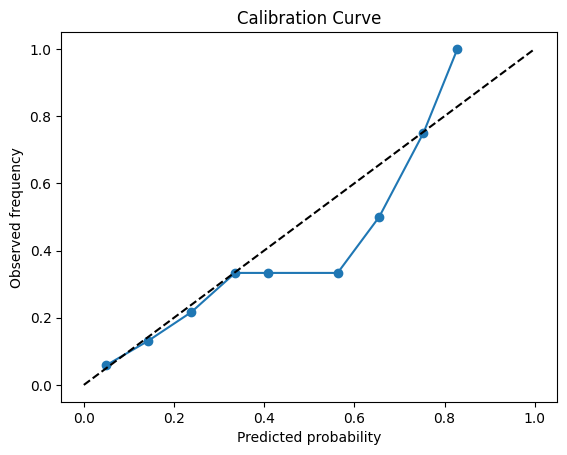

In [21]:
# GOAL 3: Evaluate the model with appropriate diagnostics.

from sklearn.metrics import (
    roc_auc_score, roc_curve,
    brier_score_loss, accuracy_score,
    confusion_matrix, precision_score,
    recall_score, f1_score
)
from sklearn.calibration import calibration_curve
import seaborn as sns
import matplotlib.pyplot as plt

# True labels and predicted probabilities
y_true = y_test
y_pred_proba = model.predict_proba(X_test)[:, 1]
y_pred_class = model.predict(X_test)

# 1. ROC-AUC Score (discrimination)
roc_auc = roc_auc_score(y_true, y_pred_proba)
print("ROC-AUC Score:", round(roc_auc, 3))

# 2. Brier Score (calibration)
brier = brier_score_loss(y_true, y_pred_proba)
print("Brier Score:", round(brier, 3))

# 3. Accuracy (at threshold=0.5)
acc = accuracy_score(y_true, y_pred_class)
print("Accuracy:", round(acc, 3))

# 4. Confusion Matrix + Precision/Recall/F1
cm = confusion_matrix(y_true, y_pred_class)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

precision = precision_score(y_true, y_pred_class)
recall = recall_score(y_true, y_pred_class)
f1 = f1_score(y_true, y_pred_class)
print(f"Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}")

# 5. ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# 6. Calibration Curve
prob_true, prob_pred = calibration_curve(y_true, y_pred_proba, n_bins=10)
plt.plot(prob_pred, prob_true, marker="o")
plt.plot([0,1], [0,1], linestyle="--", color="k")
plt.xlabel("Predicted probability")
plt.ylabel("Observed frequency")
plt.title("Calibration Curve")
plt.show()


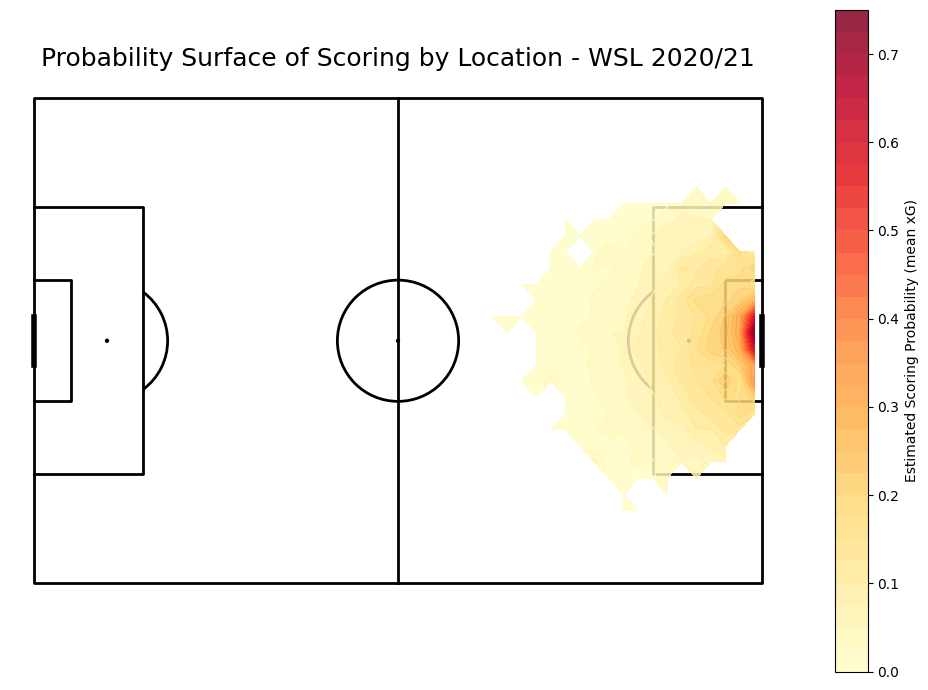

In [27]:
# GOAL 4: Probability surface (continuous field, not a heatmap)

from mplsoccer import Pitch
import numpy as np
import matplotlib.pyplot as plt

pitch = Pitch(line_color="black", pitch_type="statsbomb")
fig, ax = pitch.draw(figsize=(10, 7))

x = shots['location'].apply(lambda loc: loc[0]).values
y = shots['location'].apply(lambda loc: loc[1]).values
xg = shots['xg'].values

bin_stat = pitch.bin_statistic(x, y, values=xg, statistic='mean', bins=(50, 30))

# Z is (30, 50)
Z = np.clip(bin_stat['statistic'], 0, 1)

# These are edges -> (31, 51). Convert to 1D edges first:
x_edges = bin_stat['x_grid'][0, :]     # length 51
y_edges = bin_stat['y_grid'][:, 0]     # length 31

# Convert edges to centers -> lengths 50 and 30
x_centers = (x_edges[:-1] + x_edges[1:]) / 2
y_centers = (y_edges[:-1] + y_edges[1:]) / 2

# Make center meshgrid -> (30, 50)
Xc, Yc = np.meshgrid(x_centers, y_centers)

contour = ax.contourf(Xc, Yc, Z, levels=30, cmap="YlOrRd", alpha=0.85)

cbar = fig.colorbar(contour, ax=ax)
cbar.set_label("Estimated Scoring Probability (mean xG)")

ax.set_title("Probability Surface of Scoring by Location - WSL 2020/21", fontsize=18)
plt.show()

